In [2]:
import time
#import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import matplotlib.image as mpimg
from collections import OrderedDict
import pandas as pd

from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET 
import pandas as pd
from skimage.transform import AffineTransform, warp
from skimage.transform import rotate as rotate_transform
from skimage.util import random_noise
from skimage.filters import gaussian
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class Transforms():
    def __init__(self):
        pass
    
    def rotate(self, image, landmarks, params):

        angle = params['rotation_range'][0]
        angle = (random.uniform(0,1))*random.choice([-1,1])*angle
        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))], 
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = rotate_transform(np.array(image), angle = angle, mode = 'edge')

        landmarks = landmarks - 0.5
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5

        # PIL expects RGB images to be uint with ranges from 0 to 255 so we have to convert it to a type that PIL can excpect ie a uint from 0 to 255 
        return Image.fromarray((image * 255).astype(np.uint8)), new_landmarks

    def translation(self, image, landmarks, params):
        image_shape = np.array(image).shape
        ty = random.uniform(params['height_shift_range'][0]*image_shape[0],          
                            params['height_shift_range'][1]*image_shape[0])
        tx = random.uniform(params['width_shift_range'][0]*image_shape[1],
                            params['width_shift_range'][1]*image_shape[1] )

        
        horizontal_shift =  tx*random.choice([-1,1])
        vertical_shift = ty*random.choice([-1,1])
        horizontal_shift_normalised = horizontal_shift/image_shape[1]
        vertical_shift_normalised =  vertical_shift/image_shape[0]

        transform = AffineTransform(translation=(-horizontal_shift,-vertical_shift))

        image = warp(np.array(image),transform,mode='edge')

        landmarks = landmarks + torch.tensor([horizontal_shift_normalised,vertical_shift_normalised])
  
        # PIL expects RGB images to be uint with ranges from 0 to 255 so we have to convert it to a type that PIL can excpect ie a uint from 0 to 255 
        return Image.fromarray((image * 255).astype(np.uint8)), landmarks
        
    def resize(self, image, landmarks, img_size):
        image = TF.resize(image, img_size)
        return image, landmarks

    def zoom(self, image, landmarks, params):

        landmarks = landmarks.astype(int)
        img_shape = np.array(image).shape
        zoom = random.uniform(params['zoom_range'][0],params['zoom_range'][1])
        image = TF.resize(image,(int(img_shape[0]*zoom), int(img_shape[1]*zoom)) )
        scale_transform = torch.tensor([[zoom, 0], 
                                        [0, zoom]])
        landmarks = np.matmul(landmarks, scale_transform).float()
        new_img_shape = np.array(image).shape
        landmarks = landmarks / torch.tensor([new_img_shape[1], new_img_shape[0]])
        
        return image, landmarks

    def color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.3, 
                                              contrast=0.3,
                                              saturation=0.3, 
                                              hue=0.1)
        image = color_jitter(image)
        return image, landmarks
    


    def __call__(self, image, landmarks, params):

        # set checked image and landmark to landmark_ and image_ (this is for making sure we use the last checked tranformed instead of wrongly tranformed to do the following               # tranform)
        
        # -----------------------
        image_ = Image.fromarray(image.copy())
        landmarks_ = landmarks.copy()
        # -----------------------

        # ZOOM
        image , landmarks = self.zoom(image_, landmarks_, params)
        
        image_shape = np.array(image).shape
        landmarks_bool = landmarks < 0
        # correct this becuase hight and with is different sizes # NOTE fix
        landmarks_outofbounds = landmarks*image_shape[1]  > image_shape[1]  
        while landmarks_bool.any() or landmarks_outofbounds.any():
            image, landmarks = self.zoom(image_, landmarks_, params)
            landmarks_bool = landmarks < 0
            landmarks_outofbounds = landmarks*image_shape[1]  > image_shape[1] 

        # ----------------------
        image_ = image
        landmarks_ = landmarks
        # ----------------------

        # RESIZE
        image, landmarks = self.resize(image_, landmarks_, (224, 224))
        
        image_shape = np.array(image).shape
        landmarks_bool = landmarks < 0
        landmarks_outofbounds = landmarks*image_shape[1] > image_shape[1] 
        while landmarks_bool.any() or landmarks_outofbounds.any():
            image, landmarks = self.resize(image_, landmarks_, (224, 224))
            image_shape = np.array(image).shape
            landmarks_bool = landmarks < 0
            landmarks_outofbounds = landmarks*image_shape[1]  > image_shape[1] 
        landmarks_ = landmarks
        image_ = image

        # ----------------------
        #image_, landmarks_ = self.color_jitter(image_, landmarks_)
        # ----------------------
        
        # ROTATE
        image, landmarks = self.rotate(image_, landmarks_, params)
        
        image_shape = np.array(image).shape
        landmarks_bool = landmarks < 0
        landmarks_outofbounds = landmarks*image_shape[1] > image_shape[1] 
        while landmarks_bool.any() or landmarks_outofbounds.any():
            image, landmarks = self.rotate(image_, landmarks_, params)
            image_shape = np.array(image).shape
            landmarks_bool = landmarks < 0
            landmarks_outofbounds = landmarks*image_shape[1] > image_shape[1] 


        # ----------------------
        landmarks_ = landmarks
        image_ = image
        # ----------------------

        # TRANSLATION
        image, landmarks = self.translation(image, landmarks, params)

        image_shape = np.array(image).shape
        landmarks_bool = landmarks < 0
        landmarks_outofbounds = landmarks*image_shape[1] > image_shape[1] 
        while landmarks_bool.any() or landmarks_outofbounds.any():
            image, landmarks = self.translation(image_, landmarks_, params)
            image_shape = np.array(image).shape
            landmarks_bool = landmarks < 0
            landmarks_outofbounds = landmarks*image_shape[1] > image_shape[1] 


        # ----------------------
        landmarks_ = landmarks
        image_ = image
        # ----------------------
 
        
        image = TF.to_tensor(image)
        # the following tranform normalises each channel to have a mean at 0.5 and std of 0.5 / NOTE: NOT sure if this is theoreticlly better, should check this
        image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks


class LandmarksDataset():

    def __init__(self, transform=None,zoom = [1.0 - 0.03258157476873315, 1.0 + 0.03258157476873315], rotation = [22], height_shift= [0,0.03003200603616672], width_shift= [0,0.03003200603616672 ]):

        df = pd.read_csv('C:/Projects/msc_haar/tsetsedata_2019_left_commas/annotations_left.txt',index_col=0, header=None)

        df2 =  pd.read_csv('C:/Projects/msc_haar/flipped_left.csv', index_col= 0)
        self. tranform = transform
        self.zoom = zoom
        self.rotation = rotation
        self.height_shift = height_shift
        self.width_shift = width_shift
        self.image_filenames = []
        self.landmarks = []
        self.transform = transform
        self.image_dir = 'C:/Projects/msc_haar/tsetsedata_2019_left_commas/images_left/'
        self.image_dir2 = 'C:/Projects/msc_haar/tsetsedata_2019_right_commas/flipped_left/'
        self.TransF_ = True

       # ------------------- Append left wings data to dataset class ------------

        for filename in df.index[:]:
            self.image_filenames.append(os.path.join(self.image_dir, filename))
            

            landmarks = []
            for num in range(1, 23, 2):
                
                x_coordinate = df.loc[filename,num] - 1
                y_coordinate = df.loc[filename, num+1] - 1
                landmarks.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmarks)
        

        assert len(self.image_filenames) == len(self.landmarks)

        # ------------------ Append flipped right wings data to dataset class-----


        for filename in df2.index[:]:

            self.image_filenames.append(os.path.join(self.image_dir2, filename))

            landmarks = []
            for num in range(1, 23, 2):
                x_coordinate = df2.loc[filename,'{}'.format(num)] +1
                y_coordinate = df2.loc[filename, '{}'.format(num+1)] +1
                landmarks.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmarks)
        self.landmarks = np.array(self.landmarks).astype('float32')

        assert len(self.image_filenames) == len(self.landmarks)

        # ----------------------

    def TransF(self):
        self.TransF_ = True
    def NoTransF(self):
        self.TransF_ = False
    def set_params(self, zoom = [0.95, 0.105], rotation = [10], height_shift= [0,0.05], width_shift= [0,0.05]):
        self.zoom = zoom
        self.rotation = rotation
        self.height_shift = height_shift
        self.width_shift = width_shift
    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        params = {'zoom_range': self.zoom, 'rotation_range':self.rotation, 'height_shift_range': self.height_shift, 'width_shift_range': self.width_shift }
        image_name = self.image_filenames[index]
        image_ = plt.imread(image_name)
        landmarks_ = self.landmarks[index]
        image = plt.imread(self.image_filenames[index])
    
        landmarks = self.landmarks[index]
        
        if self.transform and self.TransF_:
            
            image, landmarks = self.transform(image_, landmarks_, params)
            image_shape = image.shape
            landmarks_bool = landmarks < 0
            landmarks_outofbounds = landmarks*224 > image_shape[1] 
            while landmarks_bool.any() or landmarks_outofbounds.any():
                image, landmarks = self.transform(image_, landmarks_, params)
                landmarks_bool = landmarks < 0
                landmarks_outofbounds = landmarks*224 > image_shape[1] 
        else:
            img_shape = image.copy().shape
            image = Image.fromarray(image)
            image = TF.resize(image, (224,224))
            landmarks = torch.tensor(landmarks) / torch.tensor([img_shape[1],img_shape[0]])
            image = TF.to_tensor(image)
            # the following tranform normalises each channel to have a mean at 0.5 and std of 0.5 / NOTE: NOT sure if this is theoreticlly better, should check this
            image = TF.normalize(image, [0.5], [0.5])



        landmarks = torch.tensor(landmarks) - 0.5
        return image, landmarks, image_name


dataset = LandmarksDataset(Transforms())






class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

'''
You instantiate it with the same arguments used for the normalize. and then use it the same way

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
unorm(tensor)

'''


class resnet50(nn.Module):
    def __init__(self,num_classes=22):
        super().__init__()
        self.model_name='resnet50'
        self.model=models.resnet50(pretrained=True)
        self.model.conv1=nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

dataset.NoTransF()
#DataSet.resize(244)

# split the dataset into validation and test sets
len_valid_test_set = int(0.2*len(dataset)) # 60% training, 20% validation, 20% testing

len_train_set = len(dataset) - len_valid_test_set*2

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_test_set))
print("The length of Valid set is {}".format(len_valid_test_set))

train_dataset , valid_dataset, test_dataset  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_test_set, len_valid_test_set], generator=torch.Generator().manual_seed(42))

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=15, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=15, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=None,batch_sampler=None, shuffle=False)

resnet50 = resnet50()
resnet50.load_state_dict(torch.load('C:/Projects/msc_haar/manuscript1_exp/regressors/models/model_resnet50_regressor_NoTransF_1.pth'))
resnet50.cpu()

The length of Train set is 1452
The length of Valid set is 484
The length of Valid set is 484


resnet50(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

C:\Users\dylan\AppData\Local\Temp/ipykernel_24316/3054502044.py:287: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  landmarks = torch.tensor(landmarks) - 0.5


96.73512887954712
9.54812
6.1925488


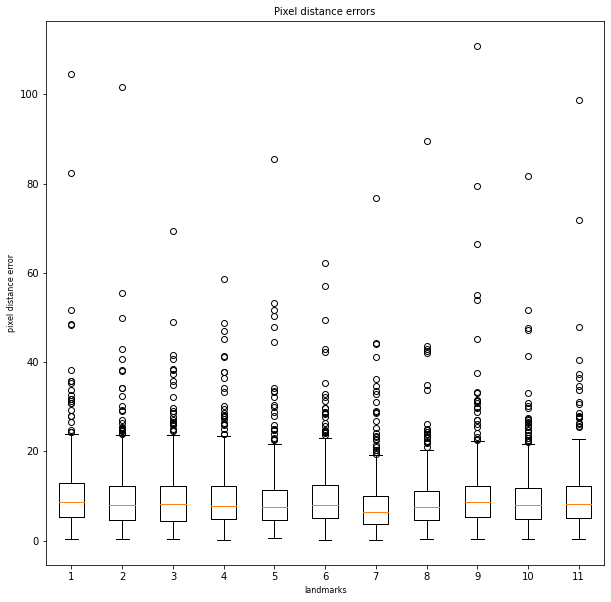

In [3]:
dataset.NoTransF()
start_time = time.time()


#best_network.cuda() 

resnet50f.eval()

predictions = torch.zeros(484, 11, 2).detach()
landmarks = torch.zeros(484, 11, 2).detach()

#images, landmarks = next(iter(test_loader))
counter = 0
with torch.no_grad():
    for images, landmark, filename in test_loader:
        images = images.detach().reshape((1,3,224,224))
        landmark = (landmark + 0.5 )*torch.tensor([1280, 1024]).detach()
        prediction = (resnet50f(images) + 0.5) 
        prediction = prediction.view(-1,11,2)*torch.tensor([1280, 1024])
        landmarks[counter,:] = landmark
        predictions[counter,:] = prediction
        predictions.detach()
        counter += 1
endtime = time.time()-start_time
print(endtime)

#print(predictions)
difs = abs(predictions - landmarks)
difs = difs.detach()

dis = np.sqrt(difs[:, :,0]**2 + difs[:, :, 1]**2)
av = []
for I in dis:
  av.append(np.mean(I.numpy()))
print(np.mean(av))
print(np.std(av))

plt.figure(figsize=(10,10))
plt.boxplot(dis.T)

plt.xlabel('landmarks', fontsize=8)
plt.ylabel('pixel distance error', fontsize=8)
plt.title('Pixel distance errors', fontsize=10)
plt.savefig('errors_resnet50.png')
plt.show()


In [11]:
difs = abs(predictions - landmarks)
difs = difs.detach()

dis = difs[:, :,0]**2 + difs[:, :, 1]**2
rms = np.sqrt(dis.sum(axis=0)/dis.shape[0])
rms.mean()



tensor(5.8643)

In [11]:
def procrustes(X, Y, scaling=True, reflection='best'):
    """
    A port of MATLAB's `procrustes` function to Numpy.
    Procrustes analysis determines a linear transformation (translation,
    reflection, orthogonal rotation and scaling) of the points in Y to best
    conform them to the points in matrix X, using the sum of squared errors
    as the goodness of fit criterion.
        d, Z, [tform] = procrustes(X, Y)
    Inputs:
    ------------
    X, Y
        matrices of target and input coordinates. they must have equal
        numbers of  points (rows), but Y may have fewer dimensions
        (columns) than X.
    scaling
        if False, the scaling component of the transformation is forced
        to 1
    reflection
        if 'best' (default), the transformation solution may or may not
        include a reflection component, depending on which fits the data
        best. setting reflection to True or False forces a solution with
        reflection or no reflection respectively.
    Outputs
    ------------
    d
        the residual sum of squared errors, normalized according to a
        measure of the scale of X, ((X - X.mean(0))**2).sum()
    Z
        the matrix of transformed Y-values
    tform
        a dict specifying the rotation, translation and scaling that
        maps X --> Y
    """

    n,m = X.shape
    ny,my = Y.shape

    muX = X.mean(0)
    muY = Y.mean(0)

    X0 = X - muX
    Y0 = Y - muY

    ssX = (X0**2.).sum()
    ssY = (Y0**2.).sum()

    # centred Frobenius norm
    normX = np.sqrt(ssX)
    normY = np.sqrt(ssY)

    # scale to equal (unit) norm
    X0 /= normX
    Y0 /= normY

    if my < m:
        Y0 = np.concatenate((Y0, np.zeros(n, m-my)),0)

    # optimum rotation matrix of Y
    A = np.dot(X0.T, Y0)
    U,s,Vt = np.linalg.svd(A,full_matrices=False)
    V = Vt.T
    T = np.dot(V, U.T)

    if reflection is not 'best':

        # does the current solution use a reflection?
        have_reflection = np.linalg.det(T) < 0

        # if that's not what was specified, force another reflection
        if reflection != have_reflection:
            V[:,-1] *= -1
            s[-1] *= -1
            T = np.dot(V, U.T)

    traceTA = s.sum()

    if scaling:

        # optimum scaling of Y
        b = traceTA * normX / normY

        # standarised distance between X and b*Y*T + c
        d = 1 - traceTA**2

        # transformed coords
        Z = normX*traceTA*np.dot(Y0, T) + muX

    else:
        b = 1
        d = 1 + ssY/ssX - 2 * traceTA * normY / normX
        Z = normY*np.dot(Y0, T) + muX

    # transformation matrix
    if my < m:
        T = T[:my,:]
    c = muX - b*np.dot(muY, T)

    #transformation values
    tform = {'rotation':T, 'scale':b, 'translation':c}

    return d, Z, tform
def generalized_procrustes(data):
    mean = data[0,...]
    print('Aligning')
    d = 100
    d_old = 100
    while d > 0.0001:
        d_new = 0
        for i in range(data.shape[0]):
            d_, data[i,:], _ = procrustes(mean, data[i,:], scaling=False, reflection=False)
            d_new += d_ / data.shape[0]
        d = d_old - d_new
        d_old = d_new
        mean = data.mean(axis=0)
    return mean

mean = generalized_procrustes(landmarks)

<>:64: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:64: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\dylan\AppData\Local\Temp/ipykernel_24316/2328989054.py:64: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if reflection is not 'best':


Aligning


In [12]:
from scipy.spatial import procrustes as procrustes_ 
procrustes_errors = {'error':[], 'procrustes_disparity':[]}
for i in range(484):
    procrustes_errors['error'].append(av[i])
    mtx1, mtx2, disparity = procrustes_(mean, landmarks[i])
    procrustes_errors['procrustes_disparity'].append(disparity)



In [6]:
proc = []
#for i in procrustes_errors['procrustes_disparity']:
#    if i>0.001:
#        proc.append(i)
errors = []
for it, i in enumerate(procrustes_errors['error']):
    #$print(it)
    mean_err = np.mean(procrustes_errors['error'])
    mean_disp = np.mean(procrustes_errors['procrustes_disparity'])
    std_err = np.std(procrustes_errors['error'])*2
    std_disp = np.std(procrustes_errors['procrustes_disparity'])*2
    i_p = procrustes_errors['procrustes_disparity'][it]
    if (mean_err - std_err)<i<(mean_err + std_err) and (mean_disp-std_disp)<i_p<(mean_disp + std_disp):
        errors.append(i)
        proc.append(procrustes_errors['procrustes_disparity'][it])

0.1
0.33


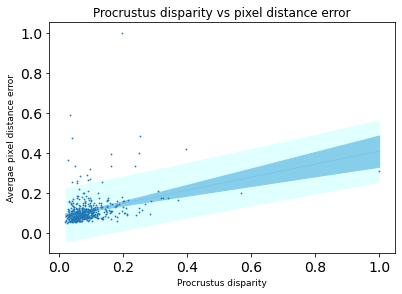

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

weights  = procrustes_errors['procrustes_disparity']

heights = procrustes_errors['error']

x = weights/max(weights)

y = heights/max(heights)
slope, intercept = np.polyfit(x, y, 1)  # linear model adjustment

y_model = np.polyval([slope, intercept], x)   # modeling...

x_mean = np.mean(x)
y_mean = np.mean(y)
n = len(x)                       # number of samples
m = 2                             # number of parameters
dof = n - m                       # degrees of freedom
t = stats.t.ppf(0.975, dof)       # Students statistic of interval confidence

residual = y - y_model

std_error = (np.sum(residual**2) / dof)**.5   # Standard deviation of the error

# calculating the r2
# https://www.statisticshowto.com/probability-and-statistics/coefficient-of-determination-r-squared/
# Pearson's correlation coefficient
numerator = np.sum((x - x_mean)*(y - y_mean))
denominator = ( np.sum((x - x_mean)**2) * np.sum((y - y_mean)**2) )**.5
correlation_coef = numerator / denominator
r2 = correlation_coef**2

# mean squared error
MSE = 1/n * np.sum( (y - y_model)**2 )

# to plot the adjusted model
x_line = np.linspace(np.min(x), np.max(x), 100)
y_line = np.polyval([slope, intercept], x_line)

# confidence interval
ci = t * std_error * (1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5
# predicting interval
pi = t * std_error * (1 + 1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5  

############### Ploting
plt.rcParams.update({'font.size': 14})
fig = plt.figure()
ax = fig.add_axes([.1, .1, .8, .8])

#, 'o', color = 'royalblue')
ax.plot(x_line, y_line, color = 'royalblue', linewidth=0.1)
ax.fill_between(x_line, y_line + pi, y_line - pi, color = 'lightcyan', label = '95% prediction interval', linewidth=0.1)
ax.fill_between(x_line, y_line + ci, y_line - ci, color = 'skyblue', label = '95% confidence interval')
ax.scatter(x, y, s = 0.6)
ax.set_xlabel('x')
ax.set_ylabel('y')

# rounding and position must be changed for each case and preference
a = str(np.round(intercept))
b = str(np.round(slope,2))
r2s = str(np.round(r2,2))
MSEs = str(np.round(MSE))

#ax.text(45, 110, 'y = ' + a + ' + ' + b + ' x')
#ax.text(45, 100, '$r^2$ = ' + r2s + '     MSE = ' + MSEs)
plt.title('Procrustus disparity vs pixel distance error',  fontsize=12)
plt.ylabel('Avergae pixel distance error',fontsize=9)
plt.xlabel('Procrustus disparity',fontsize=9)
#plt.plot([0,0.6],[0.38,0.38], linewidth=0.5, c='g', label = 'Median average pixel distance error')
#plt.plot([0.118,0.118],[0.0,1], linewidth=0.5, c='r', label = 'Median procrustus disparity')
#plt.legend( fontsize=8)
#plt.xlim([0.0,0.005])
#plt.ylim([0.0,40])
plt.savefig('linear_reg.png')
print(r2s)
print(b)

Text(0, 0.5, 'Frequency')

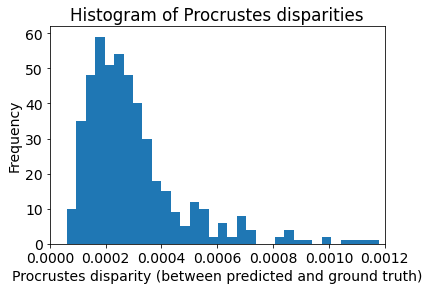

In [18]:
plt.hist(procrustes_errors['procrustes_disparity'], bins = 100)
plt.title('Histogram of Procrustes disparities')
plt.xlabel('Procrustes disparity (between predicted and ground truth)')
plt.xlim((0,0.0012))
plt.ylabel('Frequency')

In [ ]:

from scipy import stats
weights = procrustes_errors['procrustes_disparity']

heights = procrustes_errors['error']
x = weights/max(weights)

y = heights/max(heights)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
p_value